<a href="https://colab.research.google.com/github/rfarwell/MPhys/blob/main/CNN_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
       device='cuda:0')
After the average pooling function: tensor([[[[[-0.5907]]],


         [[[-0.0732]]]],



        [[[[-0.6885]]],


         [[[-0.0571]]]],



        [[[[-0.8340]]],


         [[[-0.0632]]]],



        [[[[ 0.1186]]],


         [[[-0.3070]]]]], device='cuda:0')
Before the weird conv layers: tensor([[[[[ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00],
           [ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00],
           [ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00],
           [ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00]],

          [[ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00],
           [ 3.9367e+00,  4.6107e+00,  2.9846e+01,  3.9367e+00],
           [ 3.9367e+00,  5.2379e+00,  5.6343e+01,  3.9367e+00],
           [ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00]],

          [[ 3.9367e+00,  3.9367e+00,  3.9367e+00,  3.9367e+00],
           [ 3.9367e+00,  1.4608e+01,  

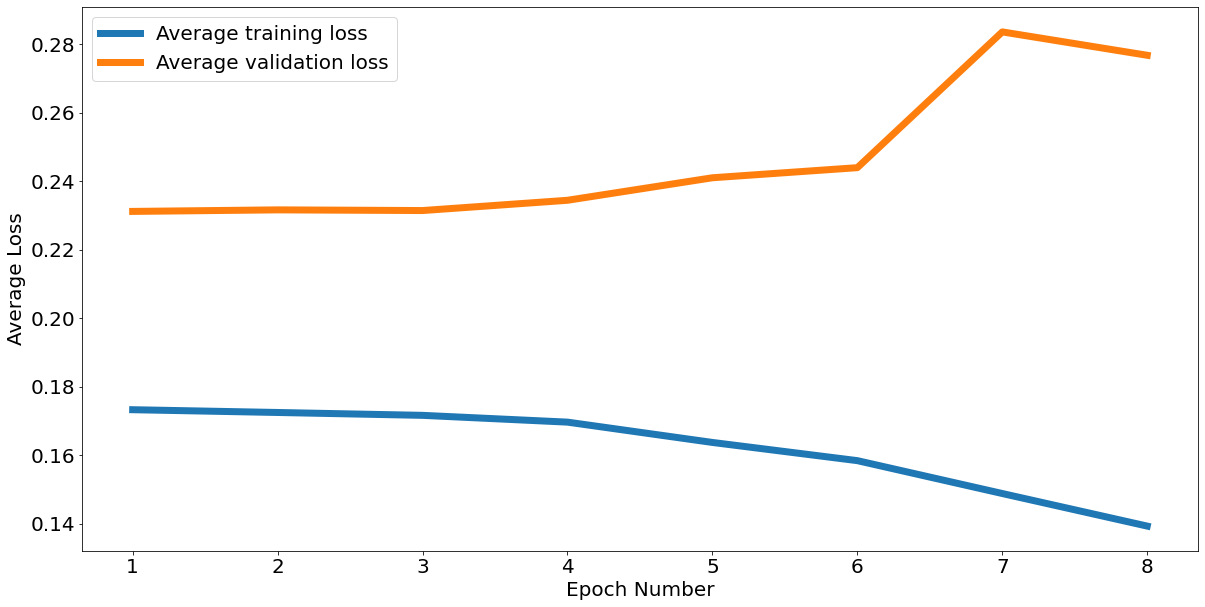

---- Currently testing the network on unseen data ----
Before the weird conv layers: tensor([[[[[ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00]],

          [[ 4.5909e+00,  7.7072e+00,  1.0542e+01,  4.5909e+00],
           [ 4.5909e+00,  4.0607e+01,  3.7696e+01,  4.5909e+00],
           [ 4.5909e+00,  4.2982e+01,  4.0429e+01,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00]],

          [[ 4.5909e+00,  5.4950e+00,  5.4685e+00,  4.5909e+00],
           [ 4.5909e+00,  3.7139e+01,  3.7519e+01,  4.5909e+00],
           [ 4.5909e+00,  4.0022e+01,  4.2937e+01,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00]],

          [[ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00],
           [ 4.5909e+00,  4.5909e+00,  4.5909e+00,  4.5909e+00],

In [1]:
"""
This code trains, validates and tests a custom binary classfiying CNN.

The inputs to the network are 264 x 264 x 264 textured masks of NSCLC pre-treatment CT scans.

Rory Farwell and Patrick Hastings 08/02/2022

"""
#====================================================================
#======================= IMPORTING FUNCTIONS ========================
#====================================================================

# Un hash below if on Google Colab
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch import reshape
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.io import read_image
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable
from torchsummary import summary

#====================================================================
#=================== COLAB SPECIFIC CODE ============================
#====================================================================

from google.colab import drive
drive.mount('/content/gdrive')

#====================================================================
#=================== SELECT DEVICE ==================================
#====================================================================

# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# /content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv
# Specify project folder location
project_folder = "/content/gdrive/MyDrive/Data"
clinical_data_filename = "NSCLC-Radiomics-Clinical-Data.csv"
print(os.path.join(project_folder, clinical_data_filename))

#====================================================================
#=================== DEFINING FUNCTIONS =============================
#====================================================================

def equalise_array_lengths(array_1, array_2) :
  """
  This functions takes in the arguments of two lists and makes sure they are returned as the same length.

  Rory Farwell 02/12/2021
  """
  # output_array = []

  # if len(array_1) > len(array_2) :
  #   array_1 = array_1[:len(array_2)]
  # elif len(array_1) < len(array_2) :
  #   array_2 = array_2[:len(array_1)]

  array_1 = array_1[:20]
  array_2 = array_2[:20]

  return (array_1, array_2)

def remove_same_elements(small_array, long_array) :
  """
  For use in the context, all the elements in small_array come from long_array.
  This function will remove all of the elements used in small_array from_long_array.  
  """
  for element in small_array :
    long_array.remove(element)
  return long_array

def create_subgroup(input_array, original_array_length, desired_percentage) :
  """
  This function outputs a subgroup array (e.g. training array) using a specified output array name,
  input array and percentage length
  """
  desired_length = int(original_array_length * desired_percentage)
  output_array = random.sample(input_array, desired_length)
  return output_array

def open_metadata() :
    """
    Opens the metadata file using the globall defined variables 'project_folder' and 'clinical_data_filename'.

    Returns patient_IDs which will be used for checking the data is shuffled
    Returns time_markers which will be used for checking patient status at a specified timepoint
    Returns dead_statuses.

    Rory Farwell and Patrick Hastings 08/02/2022
    """
    metadata_file = os.path.join(project_folder, clinical_data_filename)
    print(f'metadata_file path: {metadata_file}')
    metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
    print(f"Length of metadata array is {len(metadata)}")

    # Retrieve data from metadata file
    patient_IDs = metadata[:,0] # selecting patient IDs from the csv file
    time_markers = metadata[:,8] # selecting the day of the last patient review from the csv file
    dead_statuses = metadata[:,9] # selecting the dead status on the last review day

    time_markers = time_markers.astype(np.float32) # converting to float
    dead_statuses = dead_statuses.astype(np.float32) # converting to float

    return patient_IDs, time_markers, dead_statuses

def patient_status_on_check_day(check_day) :
    """
    Changes patient status according to patient status on the check day.
    There are 4 possibilities here:
    1. Dead: timepoint < check_day -> Dead on check day [1 -> 1]
    2. Dead: timepoint > check_day -> Alive on check day [1 -> 0]
    3. Alive: timepoint > check_day -> Alive on check day [0 -> 0]
    4. Alive: timepoint < check_day -> no info on current status -> right-censored data

    Rory Farwell and Patrick Hastings 08/02/2022
    """

    dead_counter = 0
    alive_counter = 0
    no_info_counter = 0
    dead_patient_array = []
    alive_patient_array = []

    for i in range(len(dead_statuses)) :
        temp_patient_ID = patient_IDs[i]
        temp_dead_status = dead_statuses[i]
        temp_time_marker = time_markers[i]
        if temp_dead_status == 1 : #if the patient is dead
            if temp_time_marker < check_day :# situation 1
                dead_patient_array.append([temp_patient_ID, 1])
                dead_counter += 1
                continue
            elif temp_time_marker > check_day : # situation 2
                alive_patient_array.append([temp_patient_ID, 0])
                alive_counter += 1
                continue
        elif temp_dead_status == 0 : #if the patient is alive
            if temp_time_marker < check_day : # situation 4
                no_info_counter += 1
                continue
            elif temp_time_marker > check_day :
                alive_patient_array.append([temp_patient_ID, 0])
                alive_counter += 1
                continue

    # Printing the results of this loop (the number of dead and alive patients at the check day)
    print(f"Number of patients dead after {check_day} days: {dead_counter}")
    print(f"Number of patients alive counter after {check_day} days: {alive_counter}")
    print(f"Number of right-censored data when using a check day of {check_day} days: {no_info_counter}")

    return dead_patient_array, alive_patient_array

def equalise_arrays(array_1, array_2) :
    """
    Equalise the length arrays 1 and 2 to the length of the shortest of the two.

    Rory Farwell and Patrick Hastings 08/02/2022
    """
    new_array_1 = equalise_array_lengths(array_1, array_2)[0]
    new_array_2 = equalise_array_lengths(array_1, array_2)[1]
    print(f"The alive and dead arrays have been sorted (randomly) so that they are both of length {len(new_array_1)}, {len(new_array_2)}")

    return new_array_1, new_array_2

def create_final_datasets() :
    """
    Combines the dead and alive arrays of each training, validation and testing data sets to produce the final lists.
    And shuffles them.

    Rory Farwell and Patrick Hastings 08/02/2022
    """
    outcomes_train = train_patients_dead + train_patients_alive
    outcomes_test = test_patients_dead + test_patients_alive
    outcomes_validate = validate_patients_dead + validate_patients_alive
    
    random.shuffle(outcomes_train)
    random.shuffle(outcomes_test)
    random.shuffle(outcomes_validate)

    print(f'Length of shuffled outcomes_train: {len(outcomes_train)}') 
    print(f'Length of shuffled outcomes_validate: {len(outcomes_validate)}')
    print(f'Length of shuffled outcomes_test: {len(outcomes_test)}')

    return outcomes_train, outcomes_validate, outcomes_test

def convert_to_one_hot_labels(images, labels) :
    """
    This function converts the labels to one-hot labels so that they will work with the BCEwithLogitsLoss
    """
    hot_labels = torch.empty((images.shape[0], 2))
    
    for index in range(len(labels)) :
        if labels[index] == 0 :
            hot_labels[index,0] = 1
            hot_labels[index,1] = 0
        elif labels[index] == 1 :
            hot_labels[index, 0] = 0
            hot_labels[index, 1] = 1
    
    return hot_labels

def training_loop():
    epoch_train_loss = 0 # will be used for plotting testing vs validation loss curves
    n_training_samples = 0
    print(f'Training for epoch {epoch+1}')
    print("=============================")

    model.train()

    for i, (images, labels) in enumerate(train_dataloader):
        images = reshape(images, (images.shape[0], 1, 264, 264, 264))
        images = images.float()

        hot_labels = convert_to_one_hot_labels(images, labels)
        
        images = images.to(device)
        hot_labels = hot_labels.to(device)

        print(hot_labels.size())
        print(hot_labels)

   

        #forward pass
        outputs = model(images)
        print (outputs)
        loss = criterion(outputs, hot_labels)

        #backwards pass
        optimizer.zero_grad() #clears gradients before performing backpropagation
        loss.backward()
        optimizer.step()

        # Add the number of images in this batch to n_training_samples which will
        # be used when calculating the average loss per image in the training set
        n_training_samples += labels.shape[0]

        # Updating the total training loss of this epoch
        all_training_losses.append(loss.item())
        epoch_train_loss += loss.item()

        if (i+1)%1 == 0 :
            print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

    # Append the train_loss list with the total training loss for this epoch
    train_loss.append(epoch_train_loss)

    #Append the avg_train_loss list with the average training loss of this epoch
    avg_train_loss = epoch_train_loss/n_training_samples
    print(f"Average training loss list: {avg_train_loss}")

    print(f"Training loss array at end of epoch {epoch + 1}: {train_loss}. Total number of images used = {n_training_samples}.")
    print(f"Finished training for epoch {epoch + 1}")

    return avg_train_loss

def validation_loop() :
    print(f'Validation for epoch {epoch + 1}')
    print('=================================')

    model.eval()

    with torch.no_grad(): # ensuring gradients are not calculated during the validation loop
        valid_epoch_loss = 0
        n_valid_correct = 0
        n_valid_samples = 0
        for images, labels in validation_dataloader :
            images = reshape(images, (images.shape[0],1 ,264,264,264))
            images = images.float()
            hot_labels = convert_to_one_hot_labels(images, labels)

            images = images.to(device)
            hot_labels = hot_labels.to(device)
            outputs = model(images)

            # calculate loss of validation set
            loss = criterion(outputs, hot_labels)
            valid_epoch_loss += loss.item()

            # max returns (value, index) 
            _,predictions = torch.max(outputs, 1)
            _,targets = torch.max(hot_labels, 1)
            #print(f'predictions: {predictions}')
            #print(f'targets: {targets}')
            #print(f'correct in this batch: {(predictions == targets).sum().item()}')
            n_valid_samples += labels.shape[0]
            n_valid_correct += (predictions == targets).sum().item()
            #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
        avg_valid_loss = valid_epoch_loss/n_valid_samples
        #valid_loss.append(valid_epoch_loss)
        acc = (100*n_valid_correct)/n_valid_samples
        print(f'Accuracy on validation set for epoch {epoch+1} = {acc:.1f}%')
        print(f'Loss on validation set = {valid_epoch_loss}')

        print(f'Finished validation for epoch {epoch+1}')
        print('=============================================')
    return avg_valid_loss

def testing_loop():
  print("---- Currently testing the network on unseen data ----")
  model.eval()

  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    counter = 0
    for images, labels in test_dataloader :
      # counter+=1
      # print(counter)
      images = images = reshape(images, (images.shape[0],1 ,264,264,264))
      images = images.float()
      hot_labels = convert_to_one_hot_labels(images, labels)

      images = images.to(device)
      hot_labels = hot_labels.to(device)
      outputs = model(images)
      # max returns (value, index) 
      _,predictions = torch.max(outputs, 1)
      _,targets = torch.max(hot_labels,1)
      #print(f'predictions: {predictions}')
      #print(f'targets: {targets}')
      n_samples += hot_labels.shape[0]
      n_correct += (predictions == targets).sum().item()
      #print(f'n_correct = {n_correct}. n_samples = {n_samples}')
    
    acc = (100*n_correct)/n_samples

    return acc

def plot_loss_curves() :
  new_avg_train_loss = avg_train_loss
  new_avg_valid_loss = avg_valid_loss

  epochs = np.array(range(num_epochs)) + 1
  fig = plt.figure()
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  fig.set_size_inches(20, 10)
  plt.plot(epochs, new_avg_train_loss, label = 'Average training loss',linewidth=7.0)
  plt.plot(epochs, new_avg_valid_loss, label = 'Average validation loss',linewidth=7.0)
  plt.legend(loc='best', prop={'size': 20})
  plt.ylabel('Average Loss', fontsize = 20)
  plt.xlabel('Epoch Number', fontsize = 20)
  plt.show()
  return
#====================================================================
#=================  CLASS DEFINITIONS ===============================
#====================================================================

# Normalize class added 12/12/2021
class Normalize():
  def __init__(self):
    pass

  def __call__(self,vol):
    vol =((vol-(vol.mean()))/vol.std()) + 1
    return vol

transform = transforms.Compose(
    [transforms.ToTensor(), Normalize() ] #added 13/12/2021 to normalize the inputs. THIS NORMALIZES to mean = 0 and std = 1
)


class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transform, target_transform = None) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    # ID = self.img_labels[idx][0]
    # print(f'ID: {ID}')
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]
    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label

class CNN(nn.Module):   
    def __init__(self):
        super(CNN, self).__init__()
        # self.conv1 = nn.Conv3d(1,4,2,2)
        # self.pool = nn.MaxPool3d(2,2)
        # self.avg_pool = nn.AvgPool3d(2)
        # self.conv2 = nn.Conv3d(4,16,2,2)
        # self.conv3 = nn.Conv3d(16,64,2,2)
        # self.conv4 = nn.Conv3d(64,256,2,2)
        # self.dropout = nn.Dropout(0.25)
        # self.fc1 = nn.Linear(256,64)
        # self.fc2 = nn.Linear(64,16)
        # self.fc3 = nn.Linear(16,2)

    # def __init__(self):
    #     super(CNN, self).__init__()
        # self.conv1 = nn.Conv3d(1,16,2,2)
        # self.pool = nn.MaxPool3d(2,2)
        # self.avg_pool = nn.AvgPool3d(2)
        # self.conv2 = nn.Conv3d(16,16,2,2)
        # self.conv3 = nn.Conv3d(16,16,2,2)
        # self.conv4 = nn.Conv3d(16,8,2,2)
        # self.dropout = nn.Dropout(0.25)
        # self.fc1 = nn.Linear(16,64)
        # self.fc2 = nn.Linear(64,16)
        # self.fc3 = nn.Linear(16,2)

    def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv3d(1,16,2,2)
      self.pool = nn.MaxPool3d(2,2)
      self.avg_pool = nn.AvgPool3d(4)
      self.conv2 = nn.Conv3d(16,32,2,2)
      self.conv3 = nn.Conv3d(32,64,2,2)
      self.conv4 = nn.Conv3d(64,32,1,1)
      self.conv5 = nn.Conv3d(32,8,1,1)
      self.conv6 = nn.Conv3d(8,2,1,1)

    # Defining the forward pass    (original)
    # def forward(self, x):
    #     print(f'Input to the network: {x}')
    #     x = self.pool(F.leaky_relu(self.conv1(x)))
    #     x = self.pool(F.leaky_relu(self.conv2(x)))
    #     x = self.pool(F.leaky_relu(self.conv3(x)))
    #     x = self.avg_pool(F.leaky_relu(self.conv4(x)))
    #     print(f'After average pooling layer: {x}')
    #     x = x.view(-1, 16)
    #     print(f'After flattening: {x}')
    #     x = self.dropout(x)
    #     x = F.leaky_relu(self.fc1(x))
    #     x = self.dropout(x)
    #     x = F.leaky_relu(self.fc2(x))
        
    #     x = self.dropout(x)
        
    #     x = self.fc3(x)
    #     print(x)
    #     return x

    # Defining the forward pass  (NIN method)  
    def forward(self, x):
        #print(f'Input to the network: {x}')
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        print(f'Before the weird conv layers: {x}')
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.avg_pool(self.conv6(x))
        print(f'After the average pooling function: {x}')
        x = x.view(-1,2)
        
        
        return x
        
model = CNN().to(device) # Send the CNN to the device

#====================================================================
#=================== DEFIINING VARIABLES ============================
#====================================================================

check_day = 365 * 1.5 # This is defining the timeframe for which our CNN will consider the binary output (in days) 

# sanity check to check progress
counter = 0 


# Creating empty arrays that will be appended to later
# These will contain the patient ID and dead status (on the check day).
training_array = []
testing_array = []
validation_array = []

#====================================================================
#=================== HYPER PARAMETER DEFINITION =====================
#====================================================================
batch_size = 4
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 8

#====================================================================
#=================== MAIN CODE ======================================
#====================================================================

patient_IDs, time_markers, dead_statuses = open_metadata()
dead_patient_array, alive_patient_array = patient_status_on_check_day(check_day)

#  Shuffle both arrays to ensure a random selection of patient data which will be input to the CNN
random.shuffle(dead_patient_array)
random.shuffle(alive_patient_array)

# Equalising the length of the 'dead' and 'alive' arrays so that we can ensure optimum training proportions
new_dead_patient_array, new_alive_patient_array = equalise_arrays(dead_patient_array, alive_patient_array)
equalised_array_length = len(new_alive_patient_array)

train_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.7)
train_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.7)

new_dead_patient_array = remove_same_elements(train_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(train_patients_alive, new_alive_patient_array)

test_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
test_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)

new_dead_patient_array = remove_same_elements(test_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(test_patients_alive, new_alive_patient_array)

validate_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
validate_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)

new_dead_patient_array = remove_same_elements(validate_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(validate_patients_alive, new_alive_patient_array)

print(f"After separation into training, validation and testing arrays the number of unused data is {len(new_dead_patient_array) + len(new_alive_patient_array)}. If not then something has gone wrong.")

outcomes_train, outcomes_validate, outcomes_test = create_final_datasets()

training_data = ImageDataset(outcomes_train, os.path.join(project_folder, "Textured_Masks"), transform = transform)
validation_data = ImageDataset(outcomes_validate, os.path.join(project_folder, "Textured_Masks"), transform = transform)
test_data = ImageDataset(outcomes_test, os.path.join(project_folder, "Textured_Masks"), transform = transform) 


train_dataloader = DataLoader(training_data, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = False)
validation_dataloader = DataLoader(validation_data, batch_size = 4, shuffle = True)

summary(model, (1,264,264,264), batch_size = 4)


#============================ TRAINING AND VALIDATION LOOP ==========
n_total_steps = len(train_dataloader)
train_loss = []
valid_loss = []
avg_train_loss = np.empty(0)
avg_valid_loss = np.empty(0)
all_training_losses = []

for epoch in range(num_epochs):
    avg_train_loss = np.append(avg_train_loss, training_loop())
    avg_valid_loss = np.append(avg_valid_loss, validation_loop())

print('FINISHED TRAINING')
print(f'All training batch losses = {all_training_losses}')
print(f'Training losses = {train_loss}')
print(f'Average training losses = {avg_train_loss}')
print(f'Validation losses = {avg_valid_loss}')

#===================== PLOT LOSS CURVES =============================
plot_loss_curves()

#===================== TESTING LOOP =================================
testing_accuracy = testing_loop()
print(f'Accuracy on testing set = {testing_accuracy:.1f}%')